In [20]:
!pip install adjustText
!pip install ydata-profiling


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [21]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from ydata_profiling import ProfileReport
from scipy import optimize

%matplotlib inline

# import data

In [22]:
df_data = pd.read_csv(os.path.join('dataset', 'qualitization_wanna_buy.csv'))

In [24]:
display(df_data.head())

display(df_data.describe())

display(df_data.describe(exclude = np.number))

,id,購買意欲,容量,形,色,回答者
0,0,◯,1l,円柱,青,A
1,1,×,1l,円柱,緑,A
2,2,△,1l,円柱,赤,A
3,3,◯,1l,4角柱,青,A
4,4,△,1l,4角柱,緑,A


,id
count,216.000
mean,107.500
std,62.498
min,0.000
25%,53.750
50%,107.500
75%,161.250
max,215.000


,購買意欲,容量,形,色,回答者
count,216,216,216,216,216
unique,3,3,2,3,12
top,△,1l,円柱,青,A
freq,77,72,108,72,18


Meanings

- 購買意欲: how the respondant want to buy the item
    - ◯: want to buy
    - △: medium
    - ×: don't want to buy
- 容積: volume
    - 1l: 1l
    - 500ml: 500ml
    - 300ml: 300ml
- 形: shape
    - 円柱: cylinder
    - 4角柱: quadangular-prism
- 色: color
    - 赤: Red
    - 緑: Green
    - 青: Blue
- 回答者: respondant

# Overview

In [11]:
profile = ProfileReport(df_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [14]:
profile

In [25]:
X = pd.get_dummies(df_data[['購買意欲', '容量', '形', '色']])

In [26]:
X.head()

,購買意欲_×,購買意欲_△,購買意欲_◯,容量_1l,容量_300ml,容量_500ml,形_4角柱,形_円柱,色_緑,色_赤,色_青
0,False,False,True,True,False,False,False,True,False,False,True
1,True,False,False,True,False,False,False,True,True,False,False
2,False,True,False,True,False,False,False,True,False,True,False
3,False,False,True,True,False,False,True,False,False,False,True
4,False,True,False,True,False,False,True,False,True,False,False


In [17]:
dependent_vars = ['容量_1l', '容量_500ml', '形_円柱', '色_緑', '色_青']
print(X.columns)
print(dependent_vars)

Index(['購買意欲_×', '購買意欲_△', '購買意欲_◯', '容量_1l', '容量_300ml', '容量_500ml', '形_4角柱',
       '形_円柱', '色_緑', '色_赤', '色_青'],
      dtype='object')
['容量_1l', '容量_500ml', '形_円柱', '色_緑', '色_青']


# compute variation matrices

In [29]:
# total variation

S_tot = X[dependent_vars].cov(ddof=0)

S_tot

,容量_1l,容量_500ml,形_円柱,色_緑,色_青
容量_1l,2.222222e-01,-1.111111e-01,-1.284980e-18,-3.048259e-18,-2.855512e-20
容量_500ml,-1.111111e-01,2.222222e-01,-1.284980e-18,-3.048259e-18,-2.855512e-20
形_円柱,-1.284980e-18,-1.284980e-18,2.500000e-01,0.000000e+00,0.000000e+00
色_緑,-3.048259e-18,-3.048259e-18,0.000000e+00,2.222222e-01,-1.111111e-01
色_青,-2.855512e-20,-2.855512e-20,0.000000e+00,-1.111111e-01,2.222222e-01


In [30]:
S_tot.shape

(5, 5)

In [32]:
# "within" and "between" variation
# 分散の重み付き平均
N_yes = X['購買意欲_◯'].sum()
N_middle = X['購買意欲_△'].sum()
N_no = X['購買意欲_×'].sum()

S_yes = X[X['購買意欲_◯'] == 1][dependent_vars].cov(ddof=0)
S_middle = X[X['購買意欲_△'] == 1][dependent_vars].cov(ddof=0)
S_no = X[X['購買意欲_×'] == 1][dependent_vars].cov(ddof=0)

S_within = (N_yes * S_yes + N_middle * S_middle + N_no * S_no) / (N_yes + N_middle + N_no)
S_between = S_tot - S_within

S_between

,容量_1l,容量_500ml,形_円柱,色_緑,色_青
容量_1l,0.001263,-0.007076,-0.003198,0.006138,-0.007607
容量_500ml,-0.007076,0.043597,0.021743,-0.034122,0.047363
形_円柱,-0.003198,0.021743,0.011797,-0.015287,0.023852
色_緑,0.006138,-0.034122,-0.015287,0.029847,-0.036650
色_青,-0.007607,0.047363,0.023852,-0.036650,0.051511


# Solve maximizing equation

In [10]:
# solve maximizing equation
# Via some equivariant transformation, we find that the maximam eigenvalue is the eta^2 and its eigen vector is the qualitization vector

np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))

(array([ 5.16044013e-01,  2.61031291e-02,  3.32214303e-15,  7.89622233e-16,
        -1.21961072e-16]),
 array([[ 0.26649296, -0.13352254,  0.7880698 , -0.40311129, -0.21609761],
        [ 0.7237911 , -0.03544679,  0.46999888,  0.19793654,  0.64087473],
        [ 0.26291764, -0.26988167, -0.00125907,  0.60077612, -0.62171947],
        [-0.1852907 , -0.83422522, -0.09837114, -0.16842851,  0.39118427],
        [ 0.54922638, -0.46059464, -0.38518642, -0.63954852, -0.05496516]]))

In [11]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))

idx_eta_square = np.argmax(eig_vals)
eta_square = eig_vals[idx_eta_square]
qualitization_vector = eig_vecs[:, idx_eta_square]

print('idx_eta_square:', idx_eta_square)
print('eta_square:', eta_square)
print('qualitization_vector:', qualitization_vector)


idx_eta_square: 0
eta_square: 0.5160440130950837
qualitization_vector: [ 0.26649296  0.7237911   0.26291764 -0.1852907   0.54922638]


# Compute $y$ and Visualize

In [12]:
df_data_with_y = pd.concat([df_data[['購買意欲']], X[dependent_vars]], axis=1)
df_data_with_y['y'] = X[dependent_vars].dot(qualitization_vector)

y_mean_yes = df_data_with_y[df_data_with_y['購買意欲'] == '◯']['y'].mean()
y_mean_no = df_data_with_y[df_data_with_y['購買意欲'] == '×']['y'].mean()
if y_mean_yes < y_mean_no:
    qualitization_vector = -1 * qualitization_vector
    df_data_with_y['y'] = - df_data_with_y['y']
    
df_data_with_y

,購買意欲,容量_1l,容量_500ml,形_円柱,色_緑,色_青,y
0,◯,1,0,1,0,1,1.078637
1,×,1,0,1,1,0,0.344120
2,△,1,0,1,0,0,0.529411
3,◯,1,0,0,0,1,0.815719
4,△,1,0,0,1,0,0.081202
...,...,...,...,...,...,...,...
211,×,0,0,1,1,0,0.077627
212,△,0,0,1,0,0,0.262918
213,△,0,0,0,0,1,0.549226
214,×,0,0,0,1,0,-0.185291


mean of y in each group
購買意欲
×    0.188815
△    0.522796
◯    0.991495
Name: y, dtype: float64


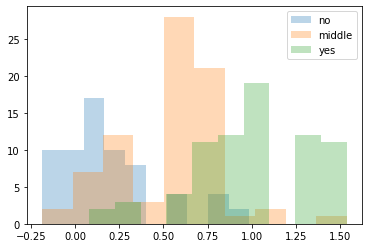

In [13]:
print('mean of y in each group')
print(df_data_with_y.groupby('購買意欲')['y'].mean())

mapper_label = {'◯': 'yes', '△': 'middle', '×': 'no'}

df_data_with_y.groupby('購買意欲')[['購買意欲', 'y']].apply(lambda x: plt.hist(x['y'], alpha=.3, label=mapper_label[x['購買意欲'].values[0]]))

plt.legend()
plt.show()

Thus, we have the result of qualitization I as:

$$
\begin{align}
    a_\text{1l} &= 0.2665 \\
    a_\text{500ml} &= 0.7238 \\
    a_\text{300ml} &= 0 \\
    a_\text{cylinder} &= 0.2629 \\
    a_\text{Quadrangular prism} &= 0 \\
    a_\text{Red} &= 0 \\
    a_\text{Green} &= -0.1852 \\
    a_\text{Blue} &= 0.5492 \\
\end{align}
$$

We can understand the following facts from the above result:
- Volume: 500ml is preferred most, 1l is the second
- Shape: cylinder is better
- Color: blue is the best, the second is red, and green is the worst
- The characteristics has capability to explain which water bottles are more likely to be preferred.
- It is reasonable to say that some types of water bottles won't be best sellers. (items with "×" are placed in left area)
- It is reasonable to say that characteristics of wanna-buy items may differ (since items with "◯" are dispersed in the graph)

これは、数量化I類の結果として、

$$
\begin{align}
    a_\text{1l} &= 0.2665 \\
    a_\text{500ml} &= 0.7238 \\
    a_\text{300ml} &= 0 \\
    a_\text{cylinder} &= 0.2629 \\
    a_\text{Quadrangular prism} &= 0 \\
    a_\text{Red} &= 0 \\
    a_\text{Green} &= -0.1852 \\
    a_\text{Blue} &= 0.5492 \\
\end{align}
$$

という意味になる。


これから、次の結果が読み取れる。
- 容積は、500mlが一番好まれ、次に1lが好まれる。
- 形は、4角柱より円柱の方が好まれる
- 色は、青が一番好まれ、次に赤、次に緑である。
- 水筒の特徴から、購買意欲がかなり説明できる（ヒストグラムより）
- 買われない商品ははっきりしている（青が左に固まっている）
- 買われる商品の特徴は、かなりばらついている可能性がある（左の方にも緑がある）
    - 好みによって、購買意欲が変わる可能性あり？

# scatter visualization of data

In [14]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))

argsort_ev = np.argsort(eig_vals)

idx_eta_square_2 = argsort_ev[-2]
eta_square_2 = eig_vals[idx_eta_square_2]
qualitization_vector_2 = eig_vecs[:, idx_eta_square_2]

print('idx_eta_square_2:', idx_eta_square_2)
print('eta_square_2:', eta_square_2)
print('qualitization_vector_2:', qualitization_vector_2)


idx_eta_square_2: 1
eta_square_2: 0.026103129052062298
qualitization_vector_2: [-0.13352254 -0.03544679 -0.26988167 -0.83422522 -0.46059464]


In [15]:
df_data_with_y['y2'] = X[dependent_vars].dot(qualitization_vector_2)
 
df_data_with_y

,購買意欲,容量_1l,容量_500ml,形_円柱,色_緑,色_青,y,y2
0,◯,1,0,1,0,1,1.078637,-0.863999
1,×,1,0,1,1,0,0.344120,-1.237629
2,△,1,0,1,0,0,0.529411,-0.403404
3,◯,1,0,0,0,1,0.815719,-0.594117
4,△,1,0,0,1,0,0.081202,-0.967748
...,...,...,...,...,...,...,...,...
211,×,0,0,1,1,0,0.077627,-1.104107
212,△,0,0,1,0,0,0.262918,-0.269882
213,△,0,0,0,0,1,0.549226,-0.460595
214,×,0,0,0,1,0,-0.185291,-0.834225


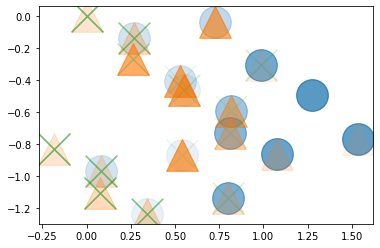

In [16]:
markers = {
    '◯': 'o',
    '△': '^',
    '×': 'x',
}

for wanna_buy in ['◯', '△', '×']:
    data = df_data_with_y[df_data_with_y['購買意欲'] == wanna_buy]
    plt.scatter(data['y'], data['y2'], s=1000, marker=markers[wanna_buy], alpha=0.1)

## scatter visualization of category

In [17]:
def centerize_qualitization(qual):
    y_volume = np.concatenate([qual[:2], [0]])
    y_shape = np.concatenate([qual[2: 3], [0]])
    y_color = np.concatenate([[0], qual[3:]])
    
    y_volume = y_volume - y_volume.mean()
    y_shape = y_shape - y_shape.mean()
    y_color = y_color - y_color.mean()
    
    return np.concatenate([y_volume, y_shape, y_color])

In [18]:
y1 = centerize_qualitization(qualitization_vector)
y2 = centerize_qualitization(qualitization_vector_2)

df_qualitization = pd.DataFrame(
    {
        'category': ['1l', '500ml', '300ml', 'cylinder', 'quad prism', 'red', 'green', 'blue'],
        'y1': y1,
        'y2': y2,
    })

df_qualitization

,category,y1,y2
0,1l,-0.063602,-0.077199
1,500ml,0.393696,0.020876
2,300ml,-0.330095,0.056323
3,cylinder,0.131459,-0.134941
4,quad prism,-0.131459,0.134941
5,red,-0.121312,0.431607
6,green,-0.306603,-0.402619
7,blue,0.427914,-0.028988


visualiztion of categories


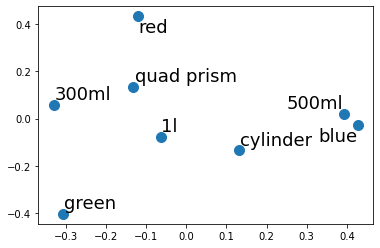

In [19]:
plt.scatter(df_qualitization['y1'], df_qualitization['y2'], s=100)
texts = [plt.text(df_qualitization['y1'][i], df_qualitization['y2'][i], df_qualitization['category'][i], fontsize=18, ha='center', va='center') for i in range(len(df_qualitization))]
adjust_text(texts)

print("visualiztion of categories")